In [195]:
import scipy.io
import mne
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import spectrogram
from scipy.stats import entropy, skew
from scipy.linalg import toeplitz, cholesky

from numpy.linalg import inv as inv #Used in kalman filter

In [196]:
# 1. 导入MAT文件
mat_data = scipy.io.loadmat('data/indy_20161005_06.mat')

In [197]:
print(type(mat_data))
for k,v in mat_data.items():
    print(f"{k}，{type(v)}")

<class 'dict'>
__header__，<class 'bytes'>
__version__，<class 'str'>
__globals__，<class 'list'>
chan_names，<class 'numpy.ndarray'>
cursor_pos，<class 'numpy.ndarray'>
finger_pos，<class 'numpy.ndarray'>
spikes，<class 'numpy.ndarray'>
t，<class 'numpy.ndarray'>
target_pos，<class 'numpy.ndarray'>
wf，<class 'numpy.ndarray'>


In [198]:
# 提取数据
chan_names = mat_data['chan_names'].flatten()  #通道数96
chan_names=np.array([k[0] for k in chan_names])
cursor_pos = mat_data['cursor_pos']  #光标的位置
finger_pos = mat_data['finger_pos']  #指尖
spikes = mat_data['spikes']          #神经数据：unsorted/sorted
t = mat_data['t'].flatten()          #采样时间戳
target_pos = mat_data['target_pos']  #目标出现的xy
wf = mat_data['wf']                  #每个通道神经元发放波形

In [199]:
print(chan_names.shape)
print(cursor_pos.shape)
print(finger_pos.shape)
print(spikes.shape)
print(t.shape)
print(target_pos.shape)
print(wf.shape)

(96,)
(93501, 2)
(93501, 3)
(96, 5)
(93501,)
(93501, 2)
(96, 5)


In [200]:
bin_width=0.04
bin_num=int(bin_width/(t[1]-t[0]))
min_t=min(t)
max_t=max(t)
bins =np.arange(min_t,max_t+bin_width,bin_width)
print("bins的形状",bins,bins.shape,bin_num)

pos_bins=np.array([cursor_pos[k] for k in range(0,len(cursor_pos),10)])
print("pos的形状",len(pos_bins))



k=0;
m,n=spikes.shape
spikes_data=[]
for row in range(m):
    tmp=[]
    for col in range(n):
        tmp+=list(spikes[row,col])
    if len(tmp)>0:
        k+=1
        spikes_data.append(tmp)

neural_data=np.zeros((len(pos_bins)-1,k))

for key,value in enumerate(spikes_data):
    hist, _ = np.histogram(value, bins)
    neural_data[:,key]=hist.T

X_kf=neural_data

bins的形状 [1288.   1288.04 1288.08 ... 1661.92 1661.96 1662.  ] (9351,) 10
pos的形状 9351


In [201]:
speed=np.zeros(pos_bins.shape) #Initialize 
time_bin=t[1]-t[0]
#Loop through time bins and determine positions based on the velocities
for i in range(1,pos_bins.shape[0]): 
    speed[i,0]=(pos_bins[i,0]-pos_bins[i-1,0])/bin_width #Note that .05 is the length of the time bin
    speed[i,1]=(pos_bins[i,1]-pos_bins[i-1,1])/bin_width

#We will now determine acceleration    
temp=np.diff(speed,axis=0) #The acceleration is the difference in velocities across time bins 

acc_binned=np.concatenate((temp[:1,:],temp),axis=0)

print(speed.shape,acc_binned.shape,pos_bins.shape)
y_kf=np.concatenate((pos_bins,speed,acc_binned),axis=1)

print(y_kf.shape)

(9351, 2) (9351, 2) (9351, 2)
(9351, 6)


In [202]:
def get_R2(y_test,y_test_pred):

    """
    Function to get R2

    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    R2_array: An array of R2s for each output
    """

    R2_list=[] #Initialize a list that will contain the R2s for all the outputs
    for i in range(y_test.shape[1]): #Loop through outputs
        #Compute R2 for each output
        y_mean=np.mean(y_test[:,i])
        R2=1-np.sum((y_test_pred[:,i]-y_test[:,i])**2)/np.sum((y_test[:,i]-y_mean)**2)
        R2_list.append(R2) #Append R2 of this output to the list
    R2_array=np.array(R2_list)
    return R2_array #Return an array of R2s




########## Pearson's correlation (rho) ##########

def get_rho(y_test,y_test_pred):

    """
    Function to get Pearson's correlation (rho)

    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    rho_array: An array of rho's for each output
    """

    rho_list=[] #Initialize a list that will contain the rhos for all the outputs
    for i in range(y_test.shape[1]): #Loop through outputs
        #Compute rho for each output
        y_mean=np.mean(y_test[:,i])
        rho=np.corrcoef(y_test[:,i].T,y_test_pred[:,i].T)[0,1]
        rho_list.append(rho) #Append rho of this output to the list
    rho_array=np.array(rho_list)
    return rho_array #Return the array of rhos


In [203]:
class KalmanFilterDecoder(object):

    """
    Class for the Kalman Filter Decoder

    Parameters
    -----------
    C - float, optional, default 1
    This parameter scales the noise matrix associated with the transition in kinematic states.
    It effectively allows changing the weight of the new neural evidence in the current update.

    Our implementation of the Kalman filter for neural decoding is based on that of Wu et al 2003 (https://papers.nips.cc/paper/2178-neural-decoding-of-cursor-motion-using-a-kalman-filter.pdf)
    with the exception of the addition of the parameter C.
    The original implementation has previously been coded in Matlab by Dan Morris (http://dmorris.net/projects/neural_decoding.html#code)
    """

    def __init__(self,C=1):
        self.C=C


    def fit(self,X_kf_train,y_train):

        """
        Train Kalman Filter Decoder

        Parameters
        ----------
        X_kf_train: numpy 2d array of shape [n_samples(i.e. timebins) , n_neurons]
            This is the neural data in Kalman filter format.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples(i.e. timebins), n_outputs]
            This is the outputs that are being predicted
        """

        #First we'll rename and reformat the variables to be in a more standard kalman filter nomenclature (specifically that from Wu et al, 2003):
        #xs are the state (here, the variable we're predicting, i.e. y_train)
        #zs are the observed variable (neural data here, i.e. X_kf_train)
        X=np.matrix(y_train.T)
        Z=np.matrix(X_kf_train.T)

        #number of time bins
        nt=X.shape[1]

        #Calculate the transition matrix (from x_t to x_t+1) using least-squares, and compute its covariance
        #In our case, this is the transition from one kinematic state to the next
        X2 = X[:,1:]
        X1 = X[:,0:nt-1]
        A=X2*X1.T*inv(X1*X1.T) #Transition matrix
        #
        Q=(X2-A*X1)*(X2-A*X1).T/(nt-1)/self.C #Covariance of transition matrix. Note we divide by nt-1 since only nt-1 points were used in the computation (that's the length of X1 and X2). We also introduce the extra parameter C here.

        #Calculate the measurement matrix (from x_t to z_t) using least-squares, and compute its covariance
        #In our case, this is the transformation from kinematics to spikes
        H = Z*X.T*(inv(X*X.T)) #Measurement matrix
        #
        R = ((Z - H*X)*((Z - H*X).T)) / nt #Covariance of measurement matrix
        params=[A,Q,H,R]
        self.model=params

    def predict(self,X_kf_test,y_test):

        """
        Predict outcomes using trained Kalman Filter Decoder

        Parameters
        ----------
        X_kf_test: numpy 2d array of shape [n_samples(i.e. timebins) , n_neurons]
            This is the neural data in Kalman filter format.

        y_test: numpy 2d array of shape [n_samples(i.e. timebins),n_outputs]
            The actual outputs
            This parameter is necesary for the Kalman filter (unlike other decoders)
            because the first value is nececessary for initialization

        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples(i.e. timebins),n_outputs]
            The predicted outputs
        """

        #Extract parameters
        A,W,H,Q=self.model

        #First we'll rename and reformat the variables to be in a more standard kalman filter nomenclature (specifically that from Wu et al):
        #xs are the state (here, the variable we're predicting, i.e. y_train)
        #zs are the observed variable (neural data here, i.e. X_kf_train)
        X=np.matrix(y_test.T)
        Z=np.matrix(X_kf_test.T)

        #Initializations
        num_states=X.shape[0] #Dimensionality of the state
        states=np.empty(X.shape) #Keep track of states over time (states is what will be returned as y_test_predicted)
        P_m=np.matrix(np.zeros([num_states,num_states]))
        # 状态转移矩阵的初值为0
        P=np.matrix(np.zeros([num_states,num_states]))
        state=X[:,0] #Initial state
        states[:,0]=np.copy(np.squeeze(state))

        #Get predicted state for every time bin
        for t in range(X.shape[1]-1):
            #Do first part of state update - based on transition matrix
            # p_m->p,W->Q,Q->R
            P_m=A*P*A.T+W
            state_m=A*state

            #Do second part of state update - based on measurement matrix
            K=P_m*H.T*inv(H*P_m*H.T+Q) #Calculate Kalman gain
            P=(np.matrix(np.eye(num_states))-K*H)*P_m
            state=state_m+K*(Z[:,t+1]-H*state_m)
            states[:,t+1]=np.squeeze(state) #Record state at the timestep
        y_test_predicted=states.T
        return y_test_predicted


In [204]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.9]
# testing_range=[0.84, 0.85]
valid_range=[0.9,1]

In [205]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(int(np.round(training_range[0]*num_examples_kf))+1,int(np.round(training_range[1]*num_examples_kf))-1)
# testing_set=np.arange(int(np.round(testing_range[0]*num_examples_kf))+1,int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(int(np.round(valid_range[0]*num_examples_kf))+1,int(np.round(valid_range[1]*num_examples_kf))-1)

print(training_set)
#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
# X_kf_test=X_kf[testing_set,:]
# y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

[   1    2    3 ... 8411 8412 8413]


In [206]:

#Z-score inputs 
X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
X_kf_train_std=np.nanstd(X_kf_train,axis=0)

X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
# X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

#Zero-center outputs
y_kf_train_mean=np.mean(y_kf_train,axis=0)
y_kf_train=y_kf_train-y_kf_train_mean
# y_kf_test=y_kf_test-y_kf_train_mean
y_kf_valid=y_kf_valid-y_kf_train_mean

同时使用位置/速度/加速度
R2: [0.46697752 0.46359196 0.27083464 0.49712911 0.05806324 0.16985784]
rho2: [0.47568531 0.62699903 0.29562207 0.49894097 0.10169452 0.18274778]


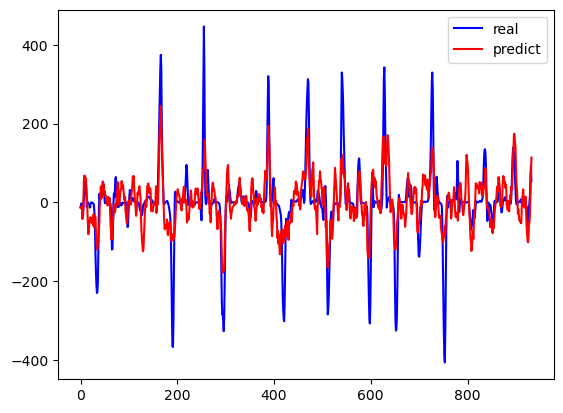

In [207]:
#Declare model
print("同时使用位置/速度/加速度")

predict_num=3
model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter that is set to the default in this example (see ReadMe)

#Fit model
model_kf.fit(X_kf_train,y_kf_train)

#Get predictions
y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2:',R2_kf) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2:',rho_kf**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

fig_x_kf=plt.figure()
plt.plot(y_kf_valid[:,predict_num]+y_kf_train_mean[predict_num-1],color='b',label="real")
plt.plot(y_valid_predicted_kf[:,predict_num]+y_kf_train_mean[predict_num-1],color='r',label="predict")
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (mV)')
# plt.title('Neuron Voltage Waveform')
plt.legend()
plt.show()


使用位置/速度
R2: [0.37403084 0.44545641 0.20891788 0.39548843]
rho2: [0.40610809 0.64527931 0.25918442 0.41112133]


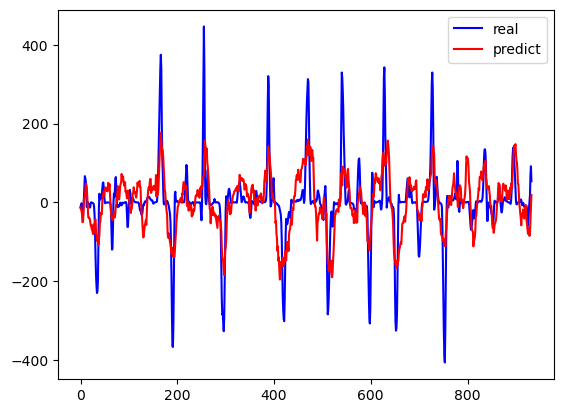

In [208]:
#Declare model
print("使用位置/速度")

kk=4
predict_num=3
model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter that is set to the default in this example (see ReadMe)

#Fit model
model_kf.fit(X_kf_train,y_kf_train[:,:kk])

#Get predictions
y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid[:,:kk])

# print(y_kf_train[:,:kk].shape,y_kf_train.shape,y_valid_predicted_kf.shape)
#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_valid[:,:kk],y_valid_predicted_kf)
print('R2:',R2_kf) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid[:,:kk],y_valid_predicted_kf)
print('rho2:',rho_kf**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

fig_x_kf=plt.figure()
plt.plot(y_kf_valid[:,predict_num]+y_kf_train_mean[predict_num-1],color='b',label="real")
plt.plot(y_valid_predicted_kf[:,predict_num]+y_kf_train_mean[predict_num-1],color='r',label="predict")
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (mV)')
# plt.title('Neuron Voltage Waveform')
plt.legend()
plt.show()

单独使用位置/速度/加速度
R2: [0.30252765 0.21674571]
rho2: [0.31891302 0.34415202]


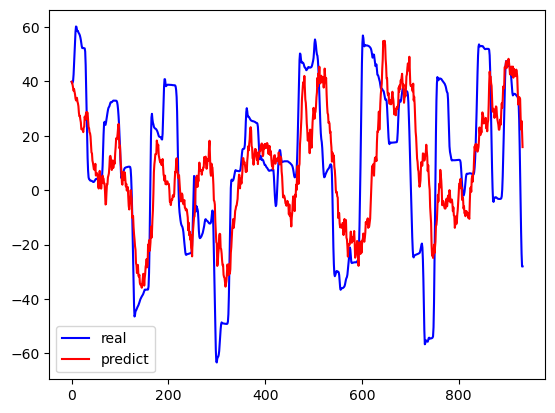

R2: [0.18213061 0.26999032]
rho2: [0.24748514 0.30398381]


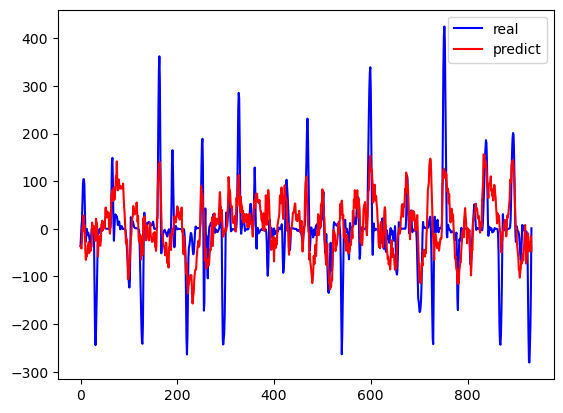

R2: [0.02139731 0.04700886]
rho2: [0.05979826 0.08052818]


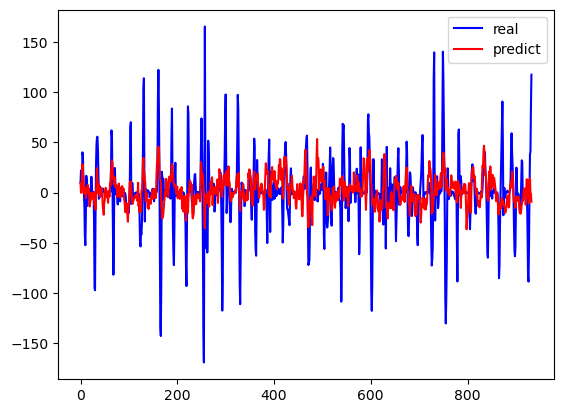

In [209]:
#Declare model
print("单独使用位置/速度/加速度")

predict_num=1
for kk in range(2,7,2):
# kk=2
    model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter that is set to the default in this example (see ReadMe)

    #Fit model
    model_kf.fit(X_kf_train,y_kf_train[:,kk-2:kk])

    #Get predictions
    y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid[:,kk-2:kk])

#     print(y_kf_train[:,kk-2:kk].shape,y_valid_predicted_kf.shape)
    #Get metrics of fit (see read me for more details on the differences between metrics)
    #First I'll get the R^2
    R2_kf=get_R2(y_kf_valid[:,kk-2:kk],y_valid_predicted_kf)
    print('R2:',R2_kf) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
    #Next I'll get the rho^2 (the pearson correlation squared)
    rho_kf=get_rho(y_kf_valid[:,kk-2:kk],y_valid_predicted_kf)
    print('rho2:',rho_kf**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

    fig_x_kf=plt.figure()
    plt.plot(y_kf_valid[:,kk-2]+y_kf_train_mean[kk-2],color='b',label="real")
    plt.plot(y_valid_predicted_kf[:,0]+y_kf_train_mean[kk-2],color='r',label="predict")
    plt.legend()
    plt.show()

R2: [0.05617726 0.23493056 0.08544446 0.18405569 0.03370461 0.07486109]
rho2: [0.10734581 0.31607177 0.09295456 0.19074844 0.04090632 0.0756729 ]


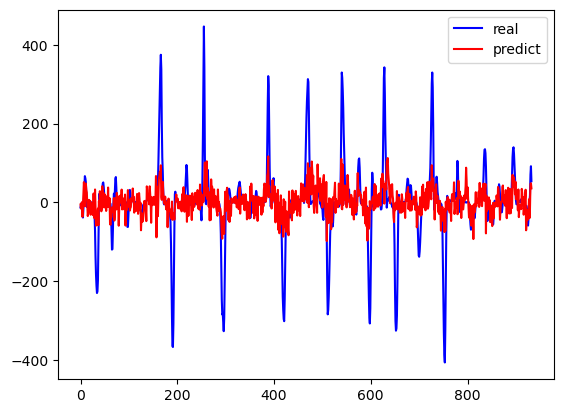

In [213]:
from sklearn.linear_model import LinearRegression
predict_num=3
model = LinearRegression()


# 拟合模型
model.fit(X_kf_train,y_kf_train)

y_valid_predicted_kf=model.predict(X_kf_valid)

R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2:',R2_kf) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2:',rho_kf**2) #I


fig_x_kf=plt.figure()
plt.plot(y_kf_valid[:,predict_num]+y_kf_train_mean[predict_num-1],color='b',label="real")
plt.plot(y_valid_predicted_kf[:,predict_num]+y_kf_train_mean[predict_num-1],color='r',label="predict")
plt.legend()
plt.show()

R2: [0.16799902 0.3785669  0.23255259 0.44941861 0.04645321 0.17716787]
rho2: [0.43233754 0.52411066 0.25838586 0.45201852 0.09075228 0.17918336]


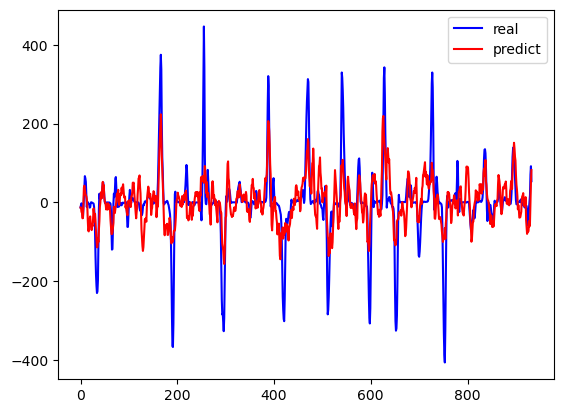

In [244]:
import Neural_Decoding
from Neural_Decoding.decoders import LSTMDecoder
predict_num=3
model = LSTMDecoder()

# 拟合模型
model_kf.fit(X_kf_train[:2000,:],y_kf_train[:2000,:])

y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2:',R2_kf) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2:',rho_kf**2) #I


fig_x_kf=plt.figure()
plt.plot(y_kf_valid[:,predict_num]+y_kf_train_mean[predict_num-1],color='b',label="real")
plt.plot(y_valid_predicted_kf[:,predict_num]+y_kf_train_mean[predict_num-1],color='r',label="predict")
plt.legend()
plt.show()